In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error, r2_score


ap_s08 = pd.read_csv('apartments_pl_2023_08.csv')
ap_s09 = pd.read_csv('apartments_pl_2023_09.csv')
ap_s10 = pd.read_csv('apartments_pl_2023_10.csv')
ap_s11 = pd.read_csv('apartments_pl_2023_11.csv')
ap_s12 = pd.read_csv('apartments_pl_2023_12.csv')
ap_s01 = pd.read_csv('apartments_pl_2024_01.csv')

population = pd.read_csv('cities_population.csv')

In [2]:
sale = pd.concat([ap_s08, ap_s09, ap_s10, ap_s11, ap_s12, ap_s01], ignore_index=True)

In [3]:
sale

,id,city,type,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,f8524536d4b09a0c8ccc0197ec9d7bde,szczecin,blockOfFlats,63.00,3.0,4.0,10.0,1980.0,53.378933,14.625296,...,0.413,condominium,concreteSlab,NaN,yes,yes,yes,no,yes,415000
1,accbe77d4b360fea9735f138a50608dd,szczecin,blockOfFlats,36.00,2.0,8.0,10.0,NaN,53.442692,14.559690,...,0.205,cooperative,concreteSlab,NaN,no,yes,yes,no,yes,395995
2,8373aa373dbc3fe7ca3b7434166b8766,szczecin,tenement,73.02,3.0,2.0,3.0,NaN,53.452222,14.553333,...,0.280,condominium,brick,NaN,no,no,no,no,no,565000
3,0a68cd14c44ec5140143ece75d739535,szczecin,tenement,87.60,3.0,2.0,3.0,NaN,53.435100,14.532900,...,0.087,condominium,brick,NaN,yes,yes,no,no,yes,640000
4,f66320e153c2441edc0fe293b54c8aeb,szczecin,blockOfFlats,66.00,3.0,1.0,3.0,NaN,53.410278,14.503611,...,0.514,condominium,NaN,NaN,no,no,no,no,no,759000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100893,204c93689b7cdc62a17ef3c0dbf7034a,bydgoszcz,tenement,98.00,3.0,NaN,3.0,1925.0,53.124655,18.008459,...,0.273,condominium,brick,NaN,no,no,no,no,yes,550000
100894,bb19da639a2de8bba49be2ca49053c87,bydgoszcz,tenement,108.96,5.0,2.0,4.0,1889.0,53.131748,18.000648,...,0.143,condominium,brick,NaN,no,no,no,no,yes,795000
100895,6a4b30b5fcdee00bfe5bcc0da82df9b1,bydgoszcz,blockOfFlats,94.30,4.0,NaN,2.0,1998.0,53.115921,17.956396,...,0.428,condominium,NaN,NaN,no,yes,no,no,yes,795000
100896,1e7f4f1fdfea31eb84e071d697839632,bydgoszcz,NaN,50.12,2.0,1.0,1.0,NaN,53.129657,18.003888,...,0.250,condominium,brick,NaN,yes,no,no,no,no,360000


In [4]:
# sprawdzamy ile jest nulli w sale
sale.isnull().sum()

id                          0
city                        0
type                    22389
squareMeters                0
rooms                       0
floor                   18263
floorCount               1371
buildYear               17201
latitude                    0
longitude                   0
centreDistance              0
poiCount                    0
schoolDistance            110
clinicDistance            438
postOfficeDistance        150
kindergartenDistance      115
restaurantDistance        284
collegeDistance          2924
pharmacyDistance          167
ownership                   0
buildingMaterial        39108
condition               76117
hasParkingSpace             0
hasBalcony                  0
hasElevator              5151
hasSecurity                 0
hasStorageRoom              0
price                       0
dtype: int64

In [5]:
# sprawdzamy jakie wartości znajdują się w kolumnie 'condition' (z największą liczbą brakujących danych)
print(sale['condition'].unique())

[nan 'low' 'premium']


In [6]:
# liczba rekordów, w których floorCount przyjmuje wartość 1, a floor ma brak danych
sale.loc[(sale['floorCount'] == 1) & (sale['floor'].isna())].shape[0]

851

In [7]:
# usuwamy kolumny id, latitude, longitude (zbędne) i condition (nie ma istotnego wpływu na naszą analizę, a ma dużo braków)
sale = sale.drop(columns=['id', 'latitude', 'longitude', 'condition'])

# zastępujemy braki danych w kolumnie floor, jeżeli floorCount przyjmuje wartość 1
# logicznie mieszkanie również musi się wtedy mieścić na piętrze 1/parterze
sale.loc[sale['floorCount'] == 1, 'floor'] = 1

# usuwamy pozostałe braki danych
sale = sale.dropna()
sale = sale.reset_index(drop=True)

# dodajemy kolumnę z ceną za m2
sale['pricePSM'] = sale['price'] / sale['squareMeters']

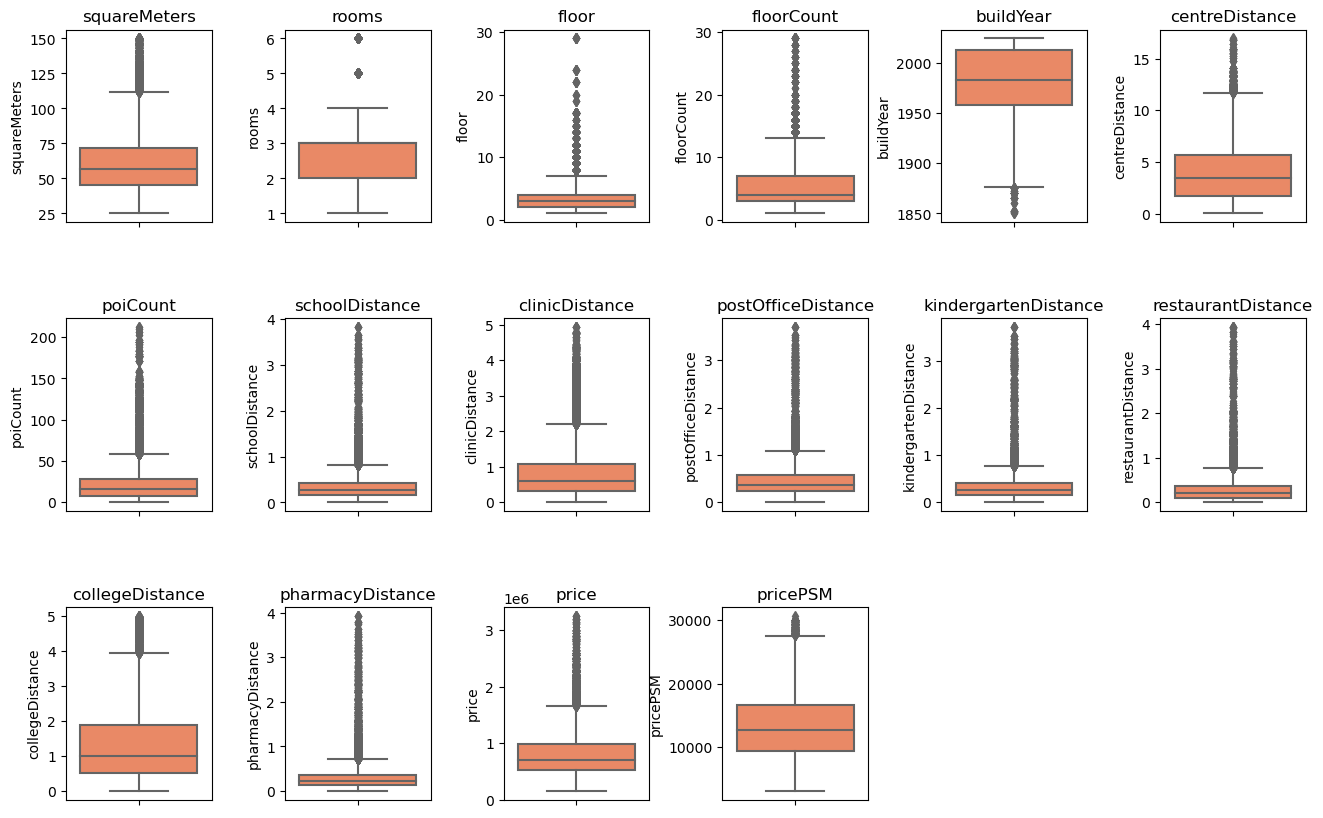

In [8]:
# wybór kolumn numerycznych
num_cols = sale.select_dtypes(['float64', 'int64']).columns
sale_nums = sale[num_cols].reset_index(drop=True)

# wybór kolumn kategorialnych
cat_cols = sale.select_dtypes(['object']).columns
sale_cats = sale[cat_cols].reset_index(drop=True)

num_features = num_cols.to_list()
cat_features = cat_cols.to_list()

# box plots - aby zobaczyć rozkład wartości
plt.figure(figsize=(16,10))
for i in range(0, len(num_features)):
    plt.subplot(3, 6, i + 1)
    sns.boxplot(y = sale_nums[num_features[i]], color = 'coral', orient = 'v')
    plt.title(num_features[i])
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

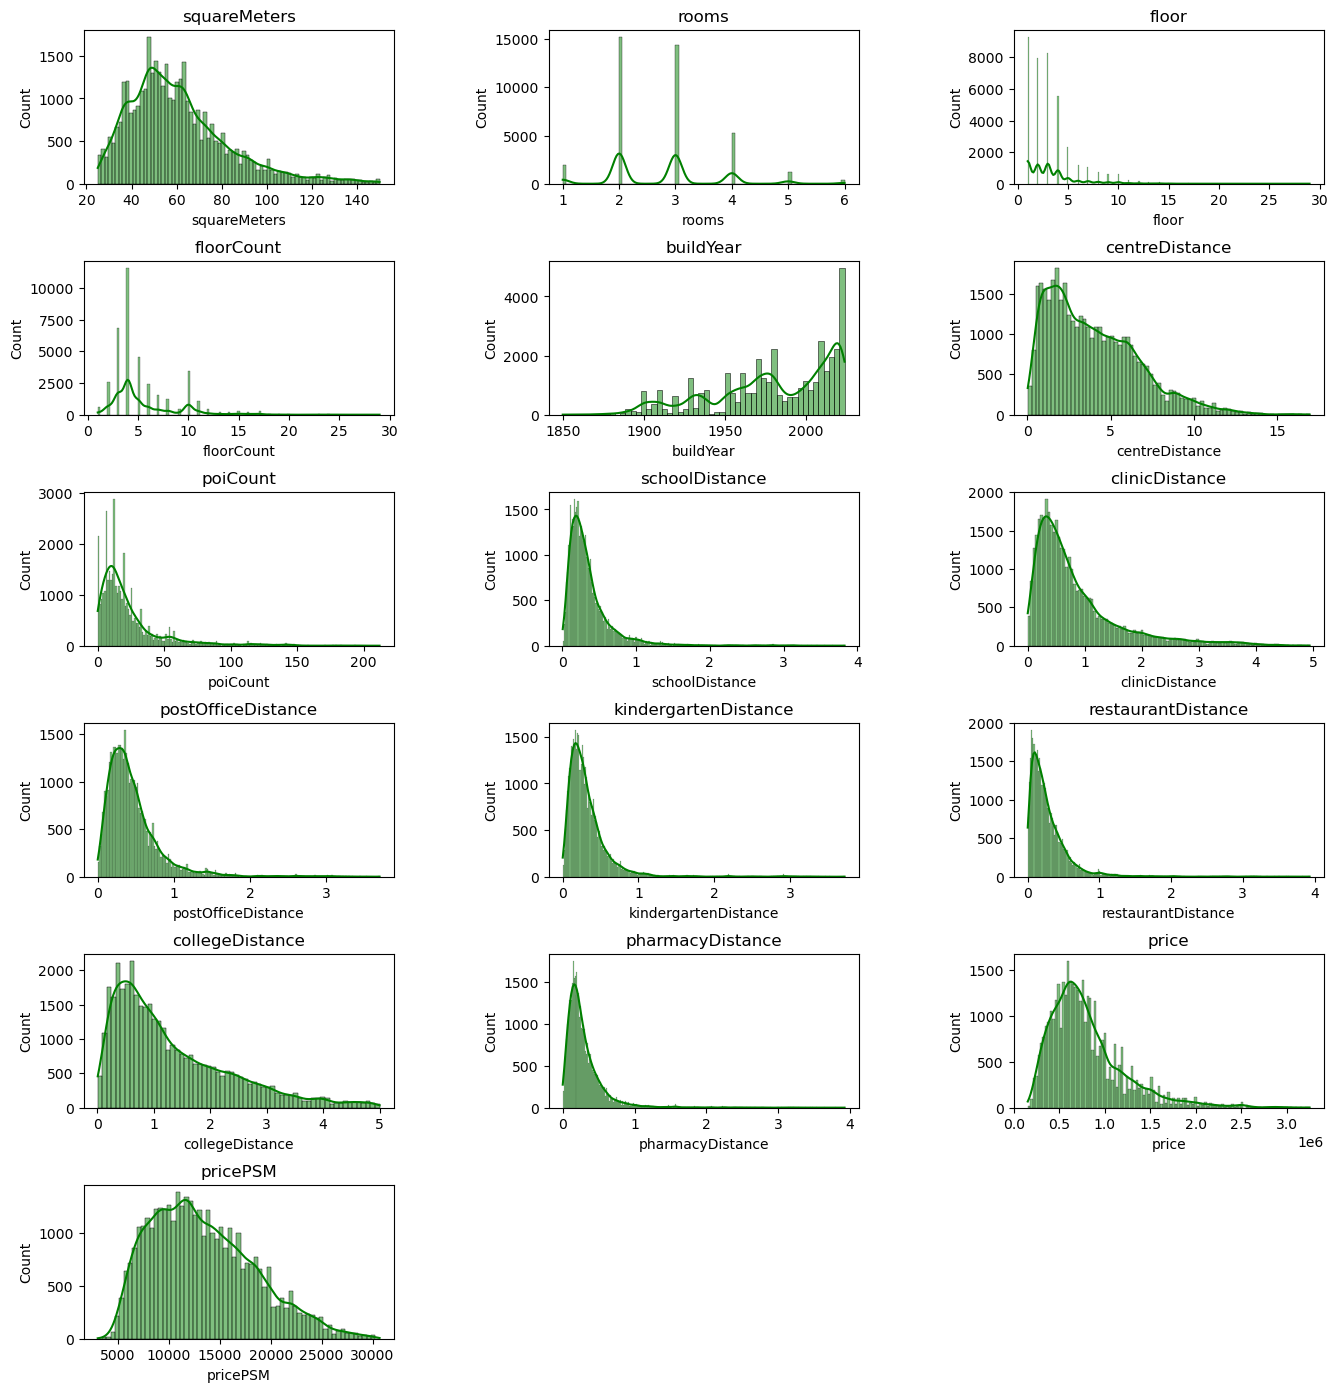

In [9]:
# histogramy - aby dokładniej przyjrzeć się wartościom w zbiorze
plt.figure(figsize = (16, 20))
for i in range(0, len(num_features)):
    plt.subplot(7,3, i+1)
    sns.histplot(x = sale[num_features[i]], kde = True, color = 'green')
    plt.title(num_features[i])
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [10]:
# funkcja do usuwania outlierów metodą 1,5*IQR
def find_outlier(df, column):
    # obliczamy 1 i 3 kwartyl
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    
    # obliczamy rozstęp ćwiartkowy
    IQR = q3 - q1
    
    # obliczamy górną i dolną granicę
    # przypadek jest odstający jeżeli leży co najmniej 1,5*IQR powyżej trzeciego kwartyla lub poniżej pierwszego kwartyla
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    
    df = df[df[column] > lower_bound]
    df = df[df[column] < upper_bound]
    return df.reset_index(drop=True)

# usuwamy wartości odstające z'poiCount' i 'centreDistance' 
sale = find_outlier(sale, 'poiCount')
sale = find_outlier(sale, 'centreDistance')

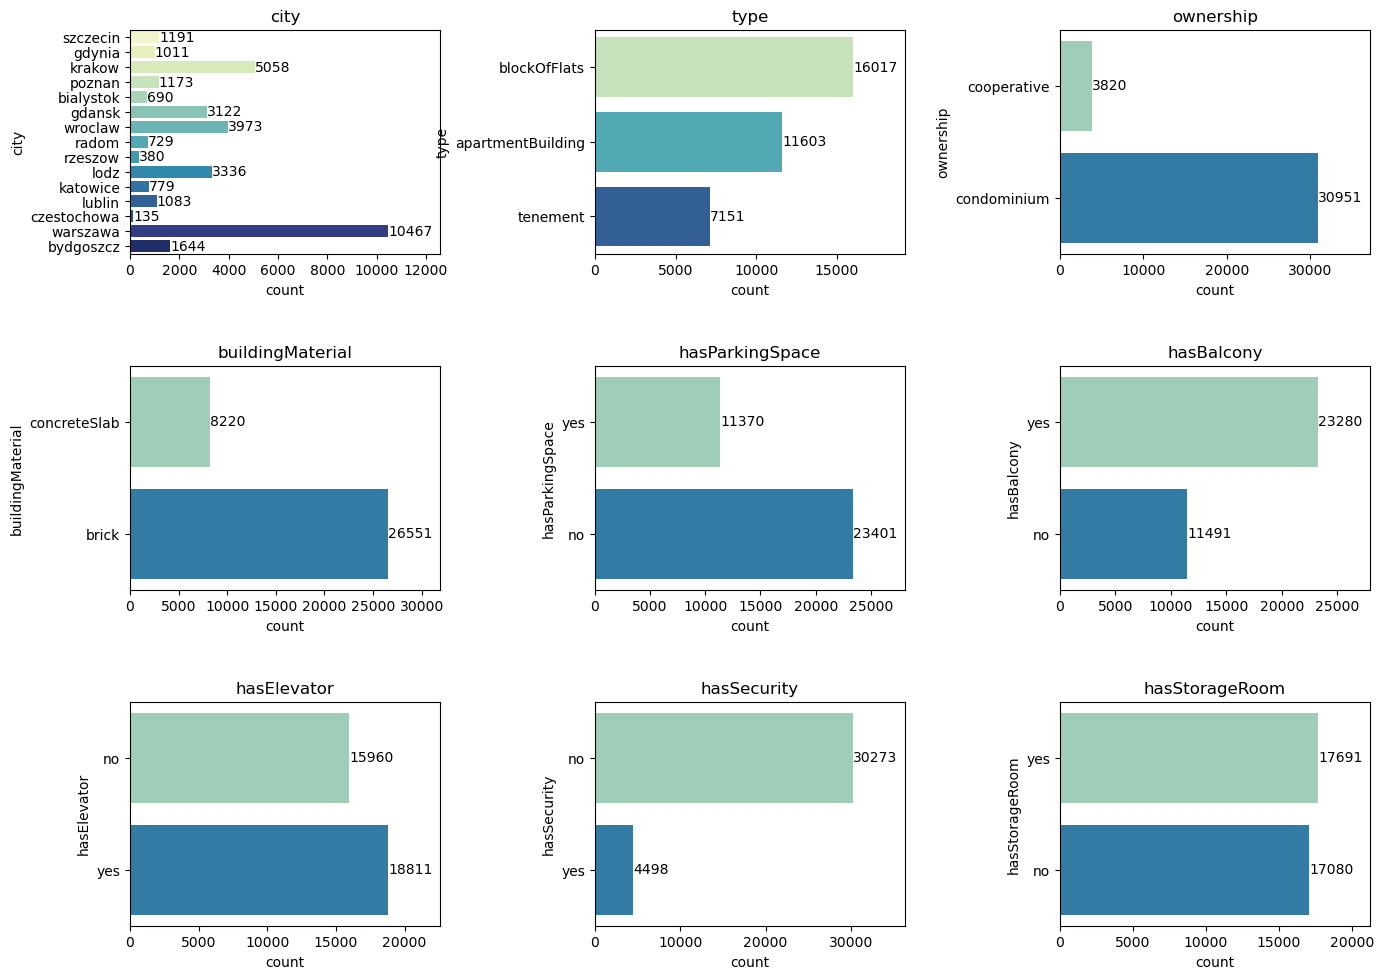

In [11]:
# countplot - aby zobaczyć rozkład wartości kategorialnych
plt.figure(figsize=(16,16))
for i in range(0, len(cat_features)):
    plt.subplot(4, 3, i+1)
    ax = sns.countplot(y = sale[cat_features[i]], palette = 'YlGnBu', orient = 'v')
    ax.set_xlim(0,sale[cat_features[i]].value_counts().max()+sale[cat_features[i]].value_counts().max()*0.2)
    ax.bar_label(ax.containers[0]);
    plt.title(cat_features[i])
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [12]:
# w kolumnie 'ownership' zamieniamy 'udział' na 'cooperative', bo to prawdopodobnie to samo
sale['ownership'].replace('udział', 'cooperative', inplace=True)

# zamieniamy miasta z 'city' na liczbę mieszkańców wybranego miasta 
sale['city'] = sale['city'].map(population.set_index('city')['population'])
sale.rename(columns={'city':'population'}, inplace=True)

cat_features.remove('city')
num_features.append('population')

sale_og = sale.copy()
# zamieniamy zmienne kategorialne na numeryczne
maping = {'yes': 1, 'no': 0,
         'tenement': 0, 'blockOfFlats': 1, 'apartmentBuilding': 2,
         'cooperative': 0, 'condominium': 1,
         'concreteSlab': 0,'brick': 1}

sale[cat_features] = sale[cat_features].applymap(lambda x: maping.get(x, x))

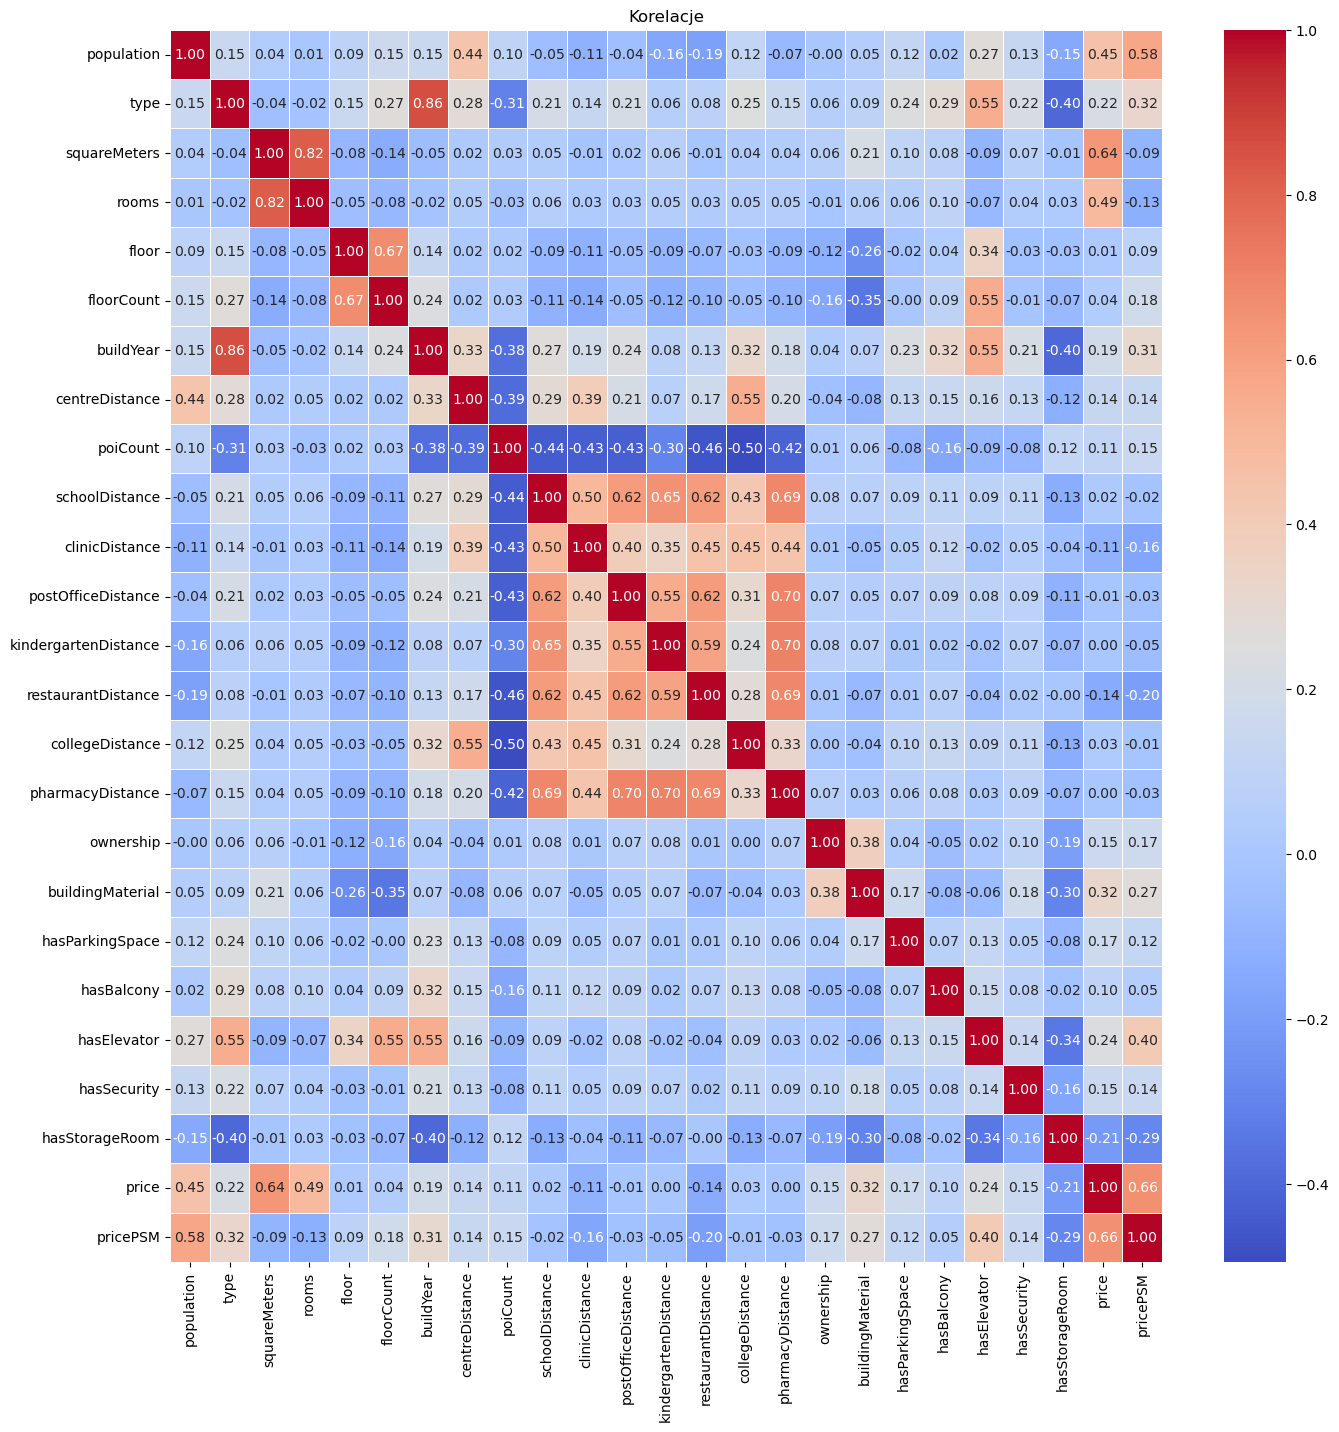

In [13]:
# macierz korelacji
sale_corr_matrix = sale.corr()

# heatmapa korelacji
plt.figure(figsize=(16, 16))
sns.heatmap(sale_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelacje')
plt.show()

In [14]:
# zmienne dotyczące dystansu obiektów są mocno ze sobą skorelowane - występuje współliniowość
# stosujemy PCA, aby skumulować skorelowane ze sobą zmienne dt. dystansu obiektów w jeden indeks 'DistancePCA'

distance_columns = ['centreDistance', 'schoolDistance', 'clinicDistance', 'postOfficeDistance', 'kindergartenDistance', 'restaurantDistance', 'collegeDistance', 'pharmacyDistance']

# standaryzacja danych
scaler = StandardScaler()
scaled_distances = scaler.fit_transform(sale[distance_columns])

# zastosowanie PCA z jedną składową główną - chcemy mieć jeden indeks
pca = PCA(n_components=1)
pca_result = pca.fit_transform(scaled_distances)

# df z wynikami
pca_df = pd.DataFrame(data=pca_result, columns=['distancePCA'])

# załadowania obrazujące jak każda zmienna odległości wpływa na składową główną (indeks)
loadings_df = pd.DataFrame(pca.components_.T, columns=['PC'], index=distance_columns)
print(loadings_df)
print(f'Procent wariancji wyjaśniony przez składową główną: {pca.explained_variance_ratio_}')

                            PC
centreDistance        0.201191
schoolDistance        0.414423
clinicDistance        0.323705
postOfficeDistance    0.384228
kindergartenDistance  0.369375
restaurantDistance    0.387411
collegeDistance       0.273136
pharmacyDistance      0.417410
Procent wariancji wyjaśniony przez składową główną: [0.5303664]


In [15]:
# nowa tabela z wynikami PCA zamiast kolumn z dystansami
sale2 = pd.concat([sale[sale.columns.difference(distance_columns)], pca_df], axis=1)
sale2

,buildYear,buildingMaterial,floor,floorCount,hasBalcony,hasElevator,hasParkingSpace,hasSecurity,hasStorageRoom,ownership,poiCount,population,price,pricePSM,rooms,squareMeters,type,distancePCA
0,1997.0,0,2.0,4.0,1,0,1,0,1,0,10.0,391566,499000,7883.096367,3.0,63.30,1,1.239227
1,1974.0,0,2.0,10.0,0,1,0,0,1,1,18.0,391566,370000,7797.681770,2.0,47.45,1,-0.705624
2,2009.0,1,3.0,4.0,1,1,0,0,0,1,8.0,391566,629000,10469.374168,2.0,60.08,2,-0.017976
3,1980.0,0,8.0,12.0,1,1,0,0,1,1,6.0,391566,399000,8354.271357,2.0,47.76,1,0.104325
4,1890.0,1,2.0,3.0,0,0,1,0,1,1,22.0,391566,325000,4508.253572,4.0,72.09,0,-1.260719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34766,1908.0,1,3.0,3.0,0,0,0,0,1,1,13.0,330038,599000,6885.057471,3.0,87.00,0,-0.759850
34767,1959.0,1,1.0,3.0,0,0,0,0,1,1,14.0,330038,389900,5268.918919,3.0,74.00,1,-0.515513
34768,2020.0,1,1.0,4.0,1,1,0,0,1,1,5.0,330038,439000,10652.754186,2.0,41.21,2,-0.214864
34769,1889.0,1,2.0,4.0,0,0,0,0,1,1,28.0,330038,795000,7296.255507,5.0,108.96,0,-1.575848


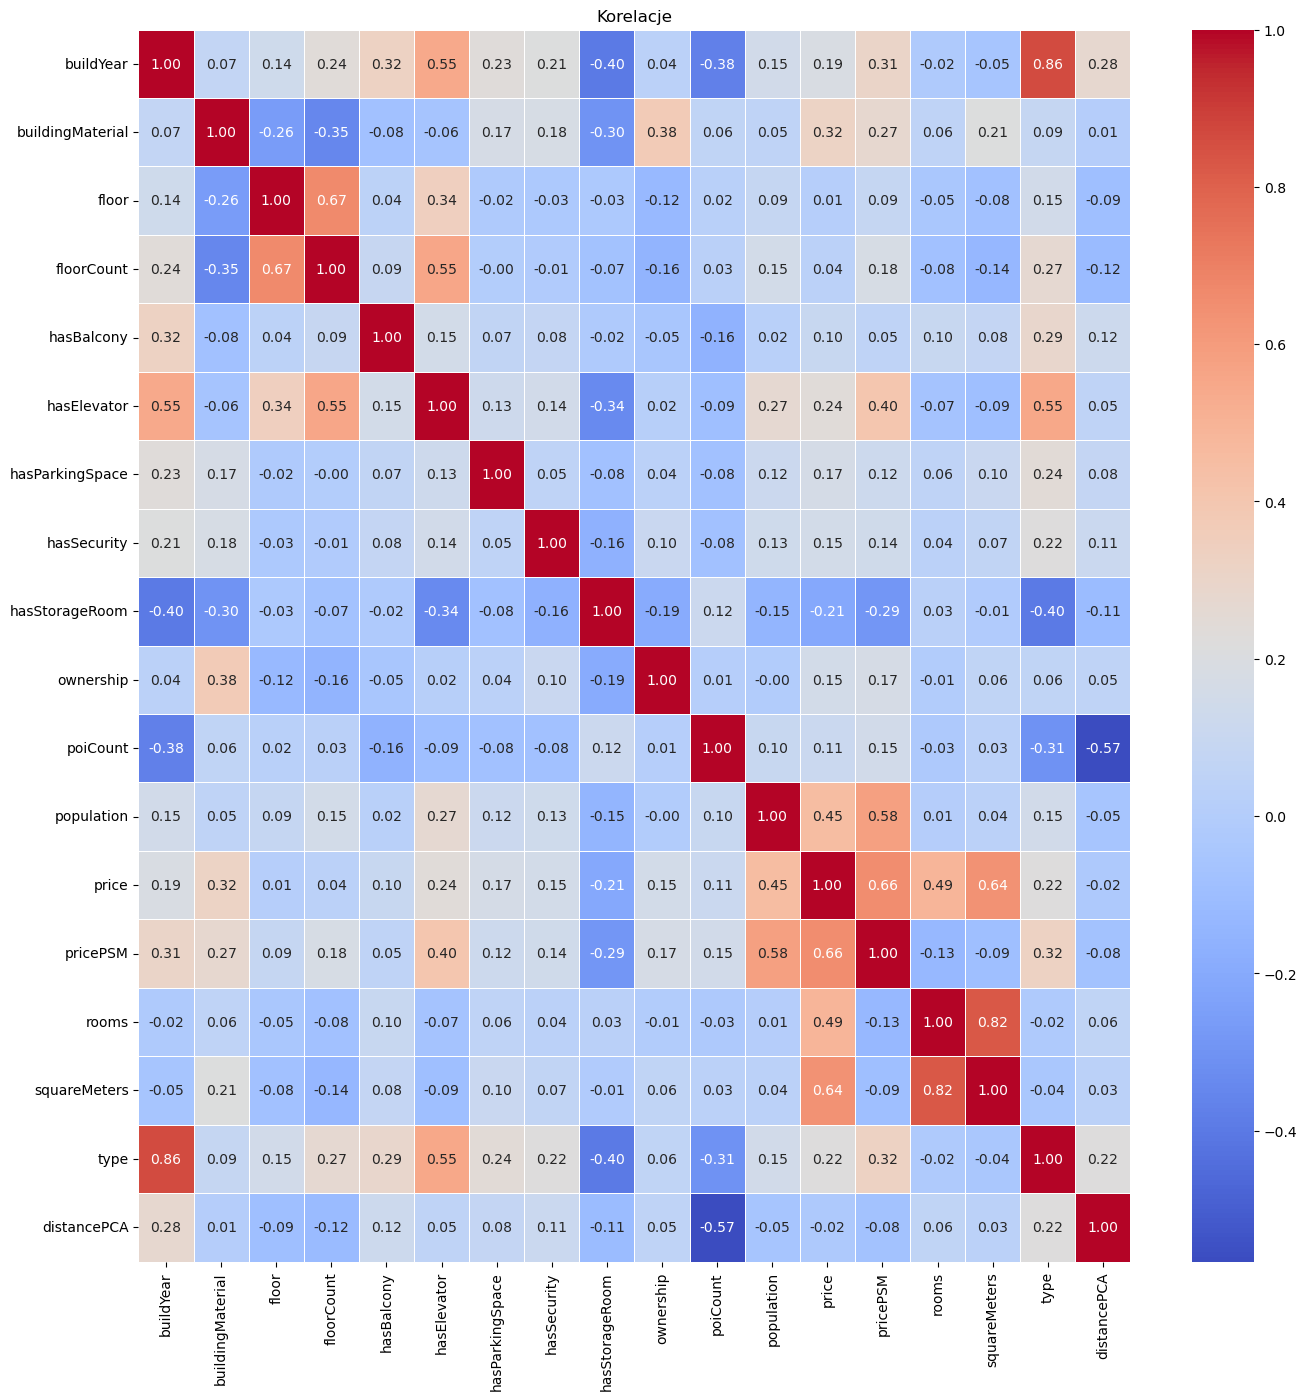

In [16]:
# macierz korelacji dla nowej tabeli
sale2_corr_matrix = sale2.corr()

# heatmapa korelacji
plt.figure(figsize=(16, 16))
sns.heatmap(sale2_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelacje')
plt.show()

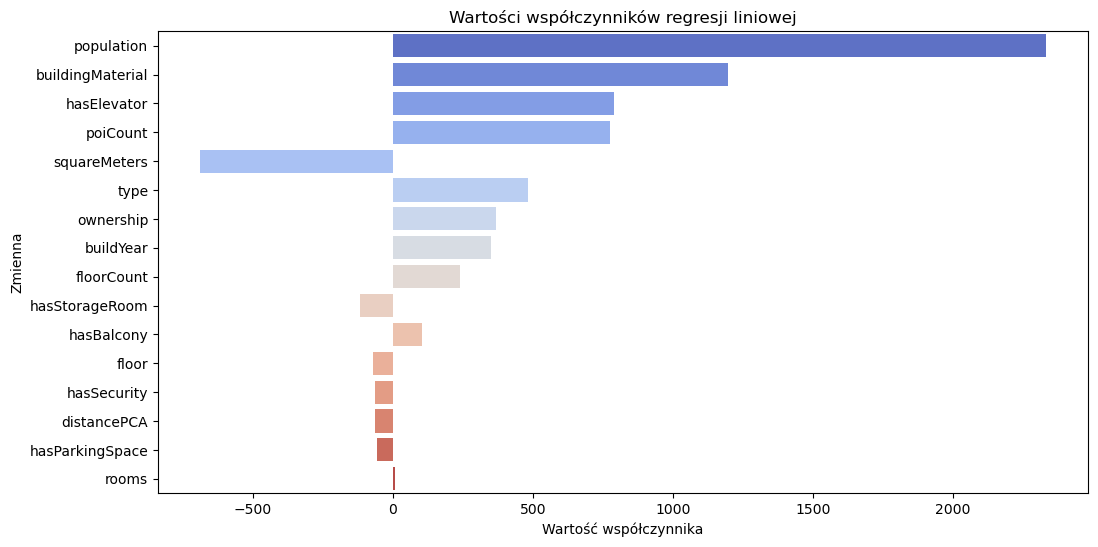

Przecięcie (intercept): 13033.006039965803


In [17]:
# usuwamy kolumnę z ceną całkowitą - nie będzie nam już potrzebna
sale2 = sale2.drop(columns=['price'])

# zmienna zależna (y) to 'price', a zmienne niezależne (X) to pozostałe kolumny
X = sale2.drop('pricePSM', axis=1)
y = sale2['pricePSM'].values

# skalowanie danych, aby wpływały na model w sposób zrównoważony
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# podział danych na zbiór uczący i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# inicjalizacja modelu regresji liniowej
model = LinearRegression()

# trenowanie modelu na zbiorze uczącym
model.fit(X_train, y_train)

# tworzymy df z współczynnikami regresji i odpowiadającymi im kolumnami
coef_df = pd.DataFrame({'Variables': X.columns, 'Coefficients': model.coef_})

# sortujemy według wartości bezwzględnych współczynników
coef_df = coef_df.reindex(coef_df['Coefficients'].abs().sort_values(ascending=False).index)

# wizualizacja
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficients', y='Variables', data=coef_df, palette='coolwarm')
plt.title('Wartości współczynników regresji liniowej')
plt.xlabel('Wartość współczynnika')
plt.ylabel('Zmienna')
plt.show()

print(f'Przecięcie (intercept): {model.intercept_}')

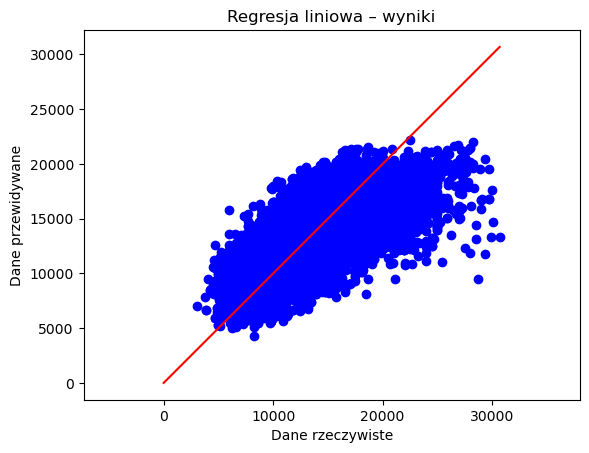

In [18]:
# przewidywanie na zbiorze testowym
y_pred = model.predict(X_test)

# dodanie prostej y=x do wykresu
min_val = min(0, min(y_test), min(y_pred))
max_val = max(0, max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red')

# wykres danych rzeczywistych vs przewidywanych
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel('Dane rzeczywiste')
plt.ylabel('Dane przewidywane')
plt.title('Regresja liniowa – wyniki')
plt.axis('equal')
plt.show()

In [19]:
# analiza jakości modelu
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'Pierwiastek błędu średniokwadratowego (RMSE): {rmse}')
print(f'R^2 (współczynnik determinacji): {r2}')

Pierwiastek błędu średniokwadratowego (RMSE): 3410.4039859135482
R^2 (współczynnik determinacji): 0.5193638258887872


In [20]:
# test F na istotność modelu ogółem
f_statistic_model, p_value_model = f_regression(X_test, y_test)
print(f"F-statistic: {f_statistic_model[0]}")
print(f"P-value: {p_value_model[0]}")

F-statistic: 747.5254505044826
P-value: 2.043753993086487e-156


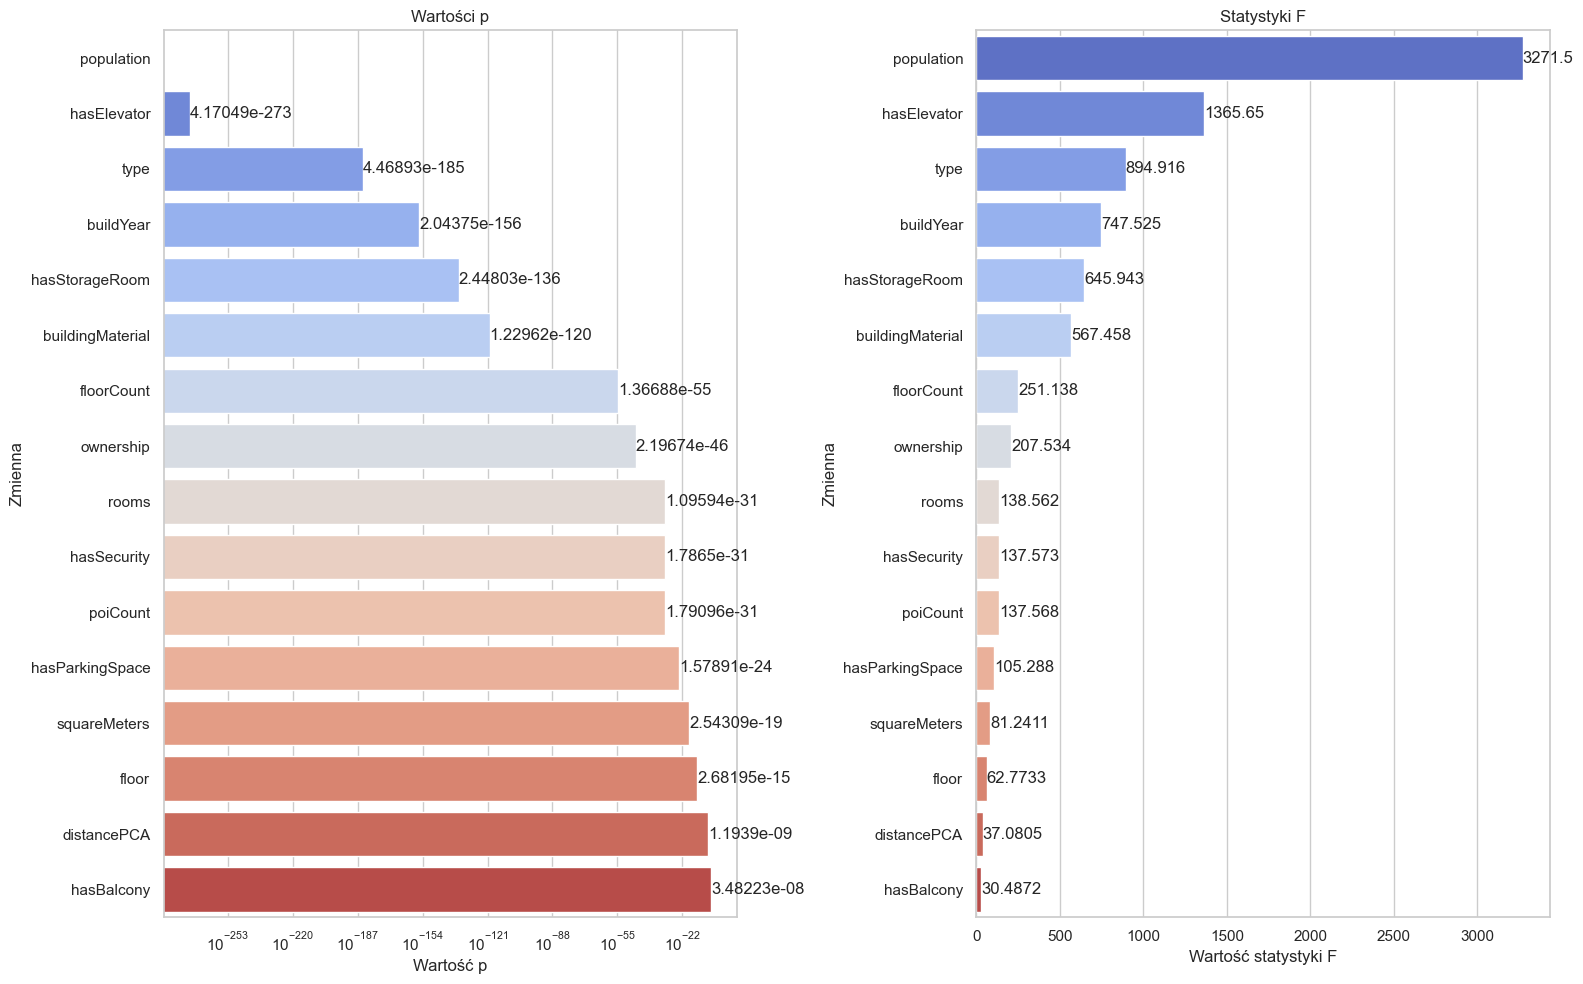

In [21]:
# tworzymy df z wartościami p, statystykami F i odpowiadającymi im kolumnami
statistic_df = pd.DataFrame({'Variables': X.columns, 'F-statistics': f_statistic_model, 'p-values': p_value_model})

# sortujemy według wartości p
statistic_df = statistic_df.reindex(statistic_df['p-values'].sort_values().index)

# wizualizacja
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")

ax1 = plt.subplot(1, 2, 1)
sns.barplot(x='p-values', y='Variables', data=statistic_df, palette='coolwarm', ax=ax1)
ax1.set_title('Wartości p')
ax1.set_xlabel('Wartość p')
ax1.set_ylabel('Zmienna')
ax1.set_xscale('log')
ax1.bar_label(ax1.containers[0])

ax2 = plt.subplot(1, 2, 2)
sns.barplot(x='F-statistics', y='Variables', data=statistic_df, palette='coolwarm', ax=ax2)
ax2.set_title('Statystyki F')
ax2.set_xlabel('Wartość statystyki F')
ax2.set_ylabel('Zmienna')
ax2.bar_label(ax2.containers[0])

plt.tight_layout()
plt.show()

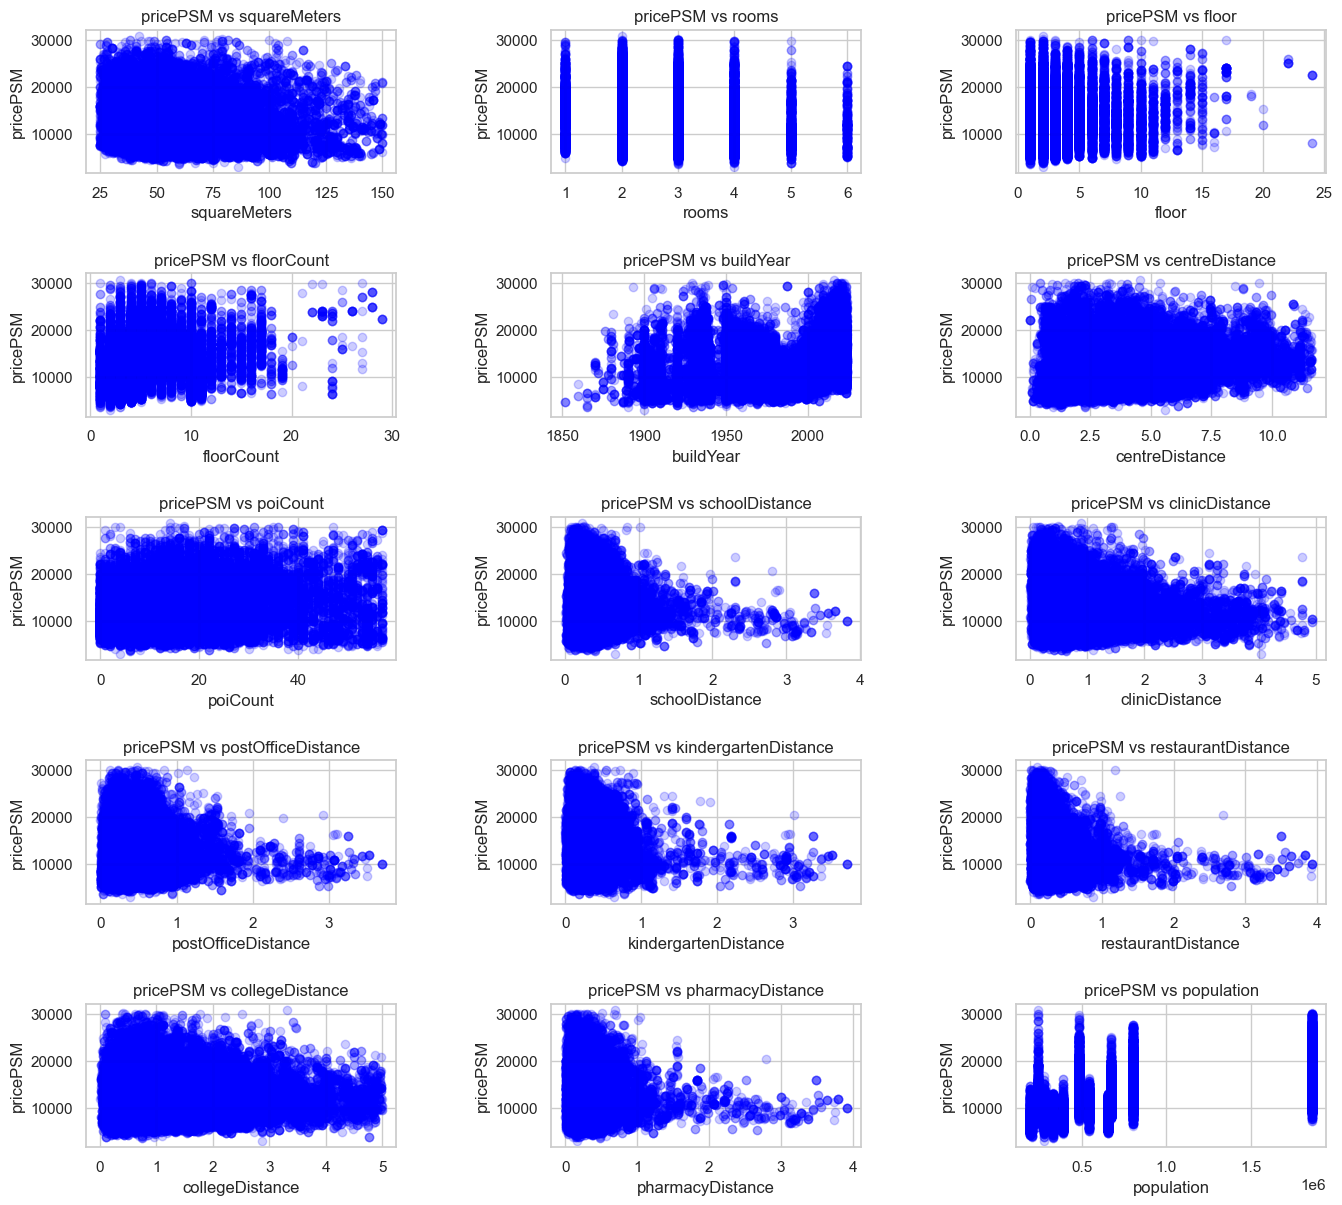

In [22]:
# scatterplot aby zobaczyć relacje price z innymi zmiennymi numerycznymi
plt.figure(figsize = (16, 24))
num_features.remove('price')
num_features.remove('pricePSM')
for i in range(0, len(num_features)):
    plt.subplot(8,3, i+1)
    plt.scatter(sale[num_features[i]], sale['pricePSM'], color='blue', alpha=0.2)
    plt.title(f'pricePSM vs {num_features[i]}')
    plt.xlabel(num_features[i])
    plt.ylabel('pricePSM')
    plt.subplots_adjust(wspace=0.5, hspace=0.7)

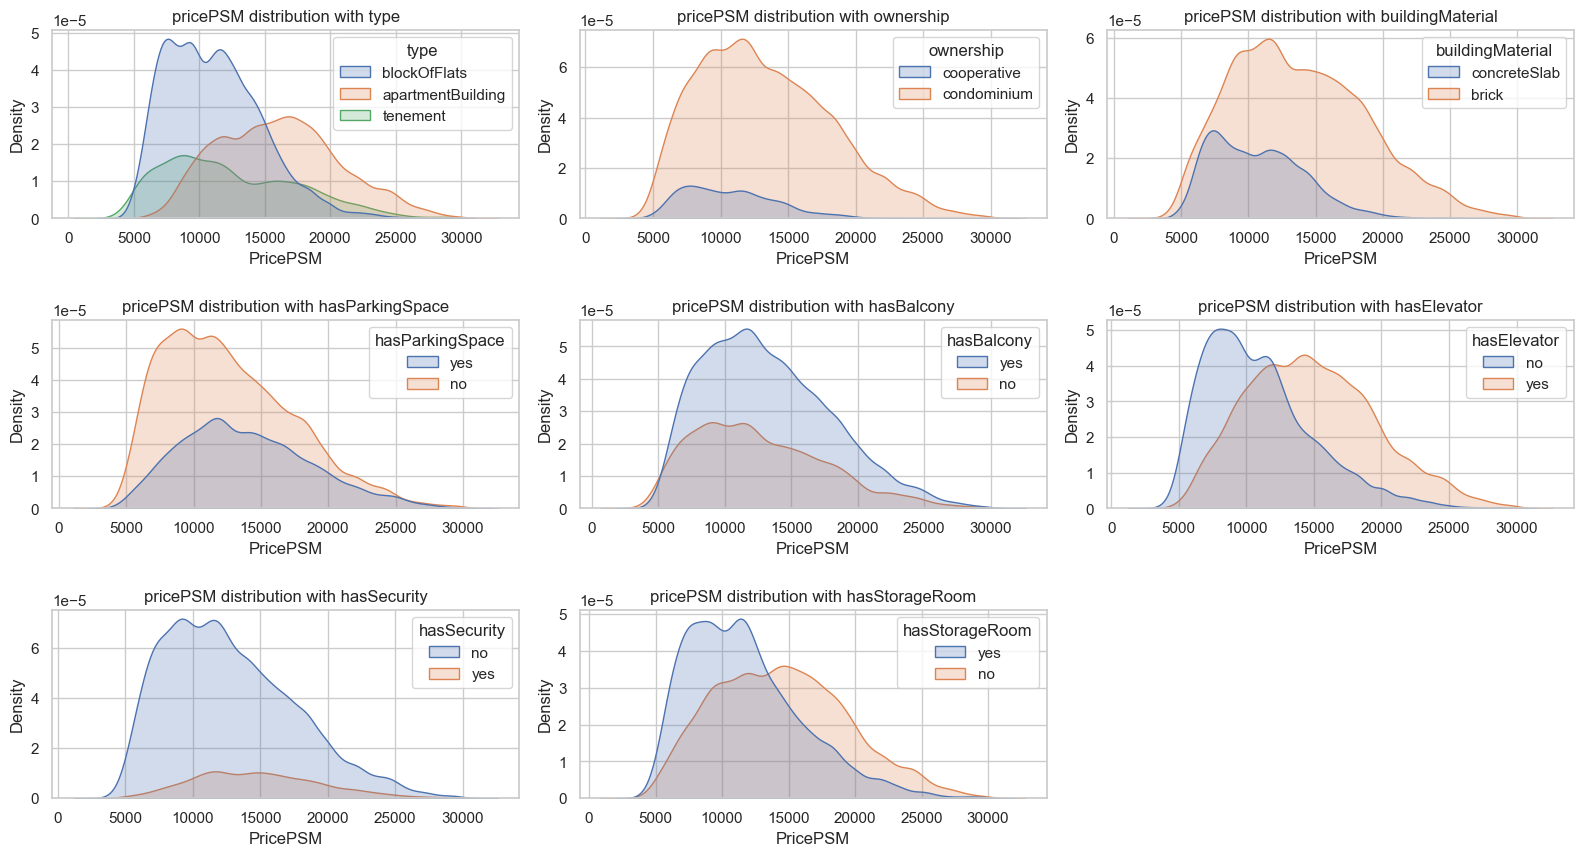

In [23]:
# kdeplot aby zobaczyć relacje price z innymi zmiennymi kategorialnymi
plt.figure(figsize=(16, 20))

for i, column in enumerate(cat_features, 1):
    plt.subplot(7, 3, i)
    sns.kdeplot(data=sale_og, x='pricePSM', hue=column, fill=True, color='coolwarm') #, common_norm=False
    plt.title(f'pricePSM distribution with {column}')
    plt.xlabel('PricePSM')    
plt.tight_layout()
plt.show()